# SIAMESE NETWORKS:

### Siamese neural networks employ a unique structure to naturally rank similarity between inputs. 
### For further study and implementation methodology take a look at: https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

# Imports

In [1]:
%matplotlib notebook

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plty
import numpy as np
import random

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


# Import MNIST

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

(60000, 28, 28)


In [3]:
x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.
x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
print(x_train.shape)

(60000, 784)


# Plots

In [4]:
def plot_triplets(examples):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (28, 28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()

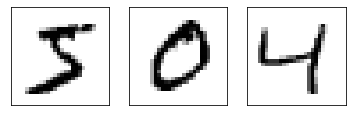

In [5]:
plot_triplets([x_train[0], x_train[1], x_train[2]])

# Creating Triplets

In [6]:
def create_batch(batch_size=256):
    x_anchors = np.zeros((batch_size, 784))
    x_positives = np.zeros((batch_size, 784))
    x_negatives = np.zeros((batch_size, 784))
    
    for i in range(0, batch_size):
        random_index = random.randint(0, x_train.shape[0] - 1)
        x_anchor = x_train[random_index]
        y = y_train[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

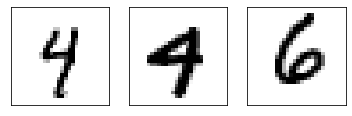

In [7]:
examples = create_batch(1)
plot_triplets(examples)

# Embedding

In [8]:
emb_size = 64

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(emb_size, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [9]:
example = np.expand_dims(x_train[0], axis=0)
example_emb = embedding_model.predict(example)[0]

print(example_emb)

[0.536669   0.48090205 0.4957411  0.54562294 0.5311687  0.53926945
 0.50446266 0.6034832  0.37867573 0.41682917 0.47507757 0.5187528
 0.638879   0.66840506 0.57640177 0.559947   0.38344762 0.5237603
 0.36517605 0.4356984  0.55865395 0.53897643 0.55822074 0.45194232
 0.526935   0.48665205 0.47119734 0.60339475 0.32592475 0.5789573
 0.5539861  0.54174393 0.5681293  0.5530574  0.5479011  0.52146256
 0.5435761  0.5174296  0.4589314  0.5111605  0.56552696 0.4445244
 0.58246434 0.5575921  0.52006125 0.64702314 0.5747978  0.5017479
 0.5000459  0.59686625 0.48429888 0.5340881  0.5272159  0.39763904
 0.546043   0.5143377  0.46748027 0.41818446 0.53157735 0.36536908
 0.6057421  0.5005526  0.45429873 0.5316582 ]


# Siamese Network

In [10]:
input_anchor = tf.keras.layers.Input(shape=(784,))
input_positive = tf.keras.layers.Input(shape=(784,))
input_negative = tf.keras.layers.Input(shape=(784,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           54400       input_1[0][0]                    
                                                                 input_2[0][0]                

# Own Loss - Triplet

In [11]:
alpha = 0.2

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

# Data Generator

In [12]:
def data_generator(batch_size=256):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

# Model

In [13]:
batch_size = 2048
epochs = 10
steps_per_epoch = int(x_train.shape[0]/batch_size)

net.compile(loss=triplet_loss, optimizer='adam')

history = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=True,
)

Epoch 1/10
29/29 [==============================] - 22s 764ms/step - loss: 0.1611
Epoch 2/10
29/29 [==============================] - 22s 755ms/step - loss: 0.0754
Epoch 3/10
29/29 [==============================] - 22s 756ms/step - loss: 0.0551
Epoch 4/10
29/29 [==============================] - 22s 761ms/step - loss: 0.0471
Epoch 5/10
29/29 [==============================] - 22s 757ms/step - loss: 0.0428
Epoch 6/10
29/29 [==============================] - 22s 762ms/step - loss: 0.0389
Epoch 7/10
29/29 [==============================] - 22s 759ms/step - loss: 0.0352
Epoch 8/10
29/29 [==============================] - 22s 761ms/step - loss: 0.0326
Epoch 9/10
29/29 [==============================] - 22s 764ms/step - loss: 0.0311
Epoch 10/10
29/29 [==============================] - 22s 758ms/step - loss: 0.0287


# PLOTTING RESULTS

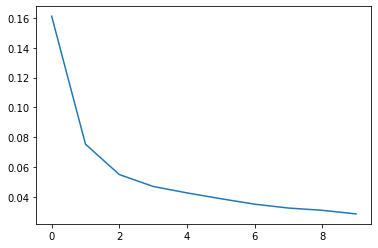

In [14]:
plt.plot(history.history['loss'])